<a href="https://colab.research.google.com/github/sanjaynagi/AgamPrimer/blob/main/Primer-Design-in-Anopheles-gambiae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First, install some packages we require
!pip install AgamPrimer==0.5.1 primer3-py malariagen_data kaleido gget -q 

In [1]:
# Import libraries 
import AgamPrimer
import pandas as pd
import malariagen_data
import numpy as np
import primer3
import matplotlib.pyplot as plt
import gget

##**AgamPrimer: Primer design considering genetic variation in *Anopheles gambiae***
**Author**: [Sanjay Curtis Nagi](https://sanjaynagi.github.io/)    
**Email**: sanjay.nagi@lstmed.ac.uk  

Often, we would like to design primers for PCR applications, such as genotyping (PCR, TaqMan, LNA) or gene expression qPCR (SYBR, TaqMan, LNA). However, single nucleotide polymorphisms (SNPs) in primer binding sites can result in differences or failures in PCR amplification, referred to as null alleles. 

In general, mismatches caused by SNPs are more of a problem as you move towards the 3' end. I recommend reading a really good article on this topic on the IDT website - [Consider SNPs when designing PCR and qPCR assays](https://eu.idtdna.com/pages/education/decoded/article/considering-snps-when-designing-pcr-and-qpcr-assays). In *An. gambiae s.l*, there is a [huge amount of genetic variation](https://genome.cshlp.org/content/30/10/1533.full); a SNP found approximately every 1.9 bases (!), which makes considering SNPs even more important when designing molecular assays. Thanks to primer3-py and the fantastic malariagen_data package, we can do all of this in the cloud, hosted by google!  

\

####**Google Colab**

If you are unfamiliar with iPython notebooks and google colab, I encourage you to read the [FAQ](https://research.google.com/colaboratory/faq.html) and watch the following [introduction](https://www.youtube.com/watch?v=inN8seMm7UI). In general, the cells contain python code, and can be run by pressing the play button next to each cell, and should be run in order.

You may want to save a copy of the notebook into your google drive (`file -> save a copy in Drive`).

In [15]:
#@title **Selecting Primer Parameters** { run: "auto" }
#@markdown In the below cells, replace the values with those desired for your primers.

assay_type = 'qPCR primers'           #@param ["gDNA primers", "gDNA primers + probe", "probe", "qPCR primers"]
assay_name = 'coeae2f'        #@param {type:"string"}
min_amplicon_size = 60        #@param {type:"integer"}
max_amplicon_size = 120      #@param {type:"integer"}
amplicon_size_range = [[min_amplicon_size, max_amplicon_size]]
n_primer_pairs = 6            #@param {type:"slider", min:1, max:20, step:1}

#@markdown    
#@markdown target_loc is required for gDNA primers and probes, and transcript required for qPCR primers.
contig =  "2L"                #@param ['2L', '2R', '3L', '3R', 'X']

target_loc =  '2422652'                #@param {type:"string"}
target_loc = int(target_loc)
transcript =  'AGAP006228-RA'         #@param {type:"string"} 


if any(item in assay_type for item in ['gDNA', 'probe']):
  assert target_loc > 0, "Target location must be above 0 and less than the contig length"
elif assay_type == 'qPCR primers':
  assert len(transcript) > 2, "Transcript ID is not valid, should be vectorbase ID such as 'AGAP004707-RD'"

Load sequence data for chromosomal arm of choice, using the [malariagen_data API](https://malariagen.github.io/vector-data/ag3/api.html):

In [16]:
# Connect to the malariagen_data ag3 API
ag3 = malariagen_data.Ag3(url='gs://vo_agam_release/') #pre=True
genome_seq = ag3.genome_sequence(region=contig)
print(f"Our genome sequence for {contig} is {genome_seq.shape[0]} bp long")

Our genome sequence for X is 24393108 bp long


Now we need to extract the bit of sequence we need. We will use functions in the [AgamPrimer](https://pypi.org/project/AgamPrimer/) package.

In [17]:
if any(item in assay_type for item in ['gDNA', 'probe']):
  # genomic DNA
  target_sequence, gdna_pos, seq_parameters = AgamPrimer.prepare_gDNA_sequence(target_loc=target_loc, amplicon_size_range=amplicon_size_range, genome_seq=genome_seq, assay_name=assay_name, assay_type=assay_type)
elif assay_type == 'qPCR primers':
  # quantitative PCR 
  target_sequence, exon_junctions, gdna_pos, seq_parameters = AgamPrimer.prepare_cDNA_sequence(transcript=transcript, gff=ag3.geneset(), genome_seq=genome_seq, assay_name=assay_name)

The target sequence is 419 bases long
the target snp is 209 bp into our target sequence


Now we have our target sequence. Lets take a look...

In [18]:
target_sequence

'CGGGAAACAGTGCTTGCCAGCGTTTGCTGGCGATGATTTATACTTATTTTTCGCTGCTCGTTTTGGGTGTATCTAACTCTTATGTCTTTTGTACTTTGGCGTACAGTAACACATCATTACAGCTGGCACGATAACTCACACACGCATACACGCTAAACTTCATCATTATGTCATGCTCATGTTTGTTAGCTACATGTGGGTTCCTTCCTTTGGCATTTTTTCGTTGTTCTTTTAAGTAATTAATGCACATttgttaggactataaacacagccgctgccgctaaatttggtatcttaggtatcaatttttgcctgtgaggcttcatcttttgactctaacgcatttttgactgtaagtcatcaattctagactctcgtaggtatcaTGATATATTTAAAAGGTTTTTGACGAGATTTAT'

We need to set up some python dictionaries containing our sequence and primer parameters, this will be our input to primer3. In the below cell, you can modify or add primer3 parameters, such as optimal TM, GC content etc etc. A full list of possible parameters and their functions can be found in the [primer3 manual](https://primer3.org/manual.html).

In [19]:
primer_parameters  =  {
        'PRIMER_NUM_RETURN':n_primer_pairs,
        'PRIMER_OPT_SIZE': 20,
        'PRIMER_TASK':'generic',
        'PRIMER_MIN_SIZE': 17,
        'PRIMER_MAX_SIZE': 24,
        'PRIMER_OPT_TM': 60.0,
        'PRIMER_MIN_TM': 57.0,
        'PRIMER_MAX_TM': 63.0,
        'PRIMER_MIN_GC': 30.0,
        'PRIMER_MAX_GC': 75.0,
        'PRIMER_PRODUCT_SIZE_RANGE': amplicon_size_range,
        'PRIMER_MIN_THREE_PRIME_DISTANCE':3,          # this parameter is the minimum distance between successive pairs. If 1, it means successive primer pairs could be identical bar one base shift
        'PRIMER_INTERNAL_OPT_SIZE': 16,               # Probe size preferences if selected, otherwise ignored
        'PRIMER_INTERNAL_MIN_SIZE': 10,
        'PRIMER_INTERNAL_MAX_SIZE': 22,
        'PRIMER_INTERNAL_MIN_TM': 45,
        'PRIMER_INTERNAL_MAX_TM':65,                # Probe considerations are quite relaxed, assumed that LNAs will be used later to affect TM
        # Extra primer3 parameters can go here
        # In the same format as above                       
    }

primer_parameters = AgamPrimer.primer_params(primer_parameters, assay_type) ## adds some parameters depending on assay type

#### **Run the primer3 algorithm!**

In [20]:
primer_dict = primer3.designPrimers(seq_args=seq_parameters, global_args=primer_parameters)

It should be *fast*. The output, which we call 'primer_dict', is a python dictionary containing the full results from primer3. We will turn this into a pandas dataframe (i.e a useful, pretty table), containing just the necessary bits of information. First, we'll print some information from the primer3 run.

In [21]:
AgamPrimer.primer3_run_statistics(primer_dict, assay_type)

primer_probe_explain  :  considered 548, overlap excluded region 400, low tm 99, long poly-x seq 5, ok 44 

primer_forward_num_returned  :  0 

primer_reverse_num_returned  :  0 

primer_probe_num_returned  :  6 

primer_pair_num_returned  :  0 



Now lets wrangle this into an easy to look at table.

In [22]:
primer_df = AgamPrimer.primer3_to_pandas(primer_dict, assay_type)
primer_df

primer_pair,0,1,2,3,4,5
parameter,,,,,,
primer_probe_sequence,TGTGGGTTCCTTCCTTTGGCA,GTGGGTTCCTTCCTTTGGCA,TGTGGGTTCCTTCCTTTGGC,TGTGGGTTCCTTCCTTTGGCAT,TGGGTTCCTTCCTTTGGCA,GTGGGTTCCTTCCTTTGGCAT
primer_probe_tm,56.12102,54.550878,54.550878,56.357826,53.094331,54.864863
primer_probe_gc_percent,52.380952,55.0,55.0,50.0,52.631579,52.380952
primer_probe,"(194, 21)","(195, 20)","(194, 20)","(194, 22)","(196, 19)","(195, 21)"



We can write this to .tsv and excel files, which can be explored in other editors. To download a file from colab to your local computer, click the folder panel on the left-hand sidebar, the three dots next your primers.tsv/.xlsx file, and download.

In [ ]:
primer_df.to_csv(f"{assay_name}.{assay_type}.primers.tsv", sep="\t")
primer_df.to_excel(f"{assay_name}.{assay_type}.primers.xlsx")

##**Looking for variation using the ag1000g resource and malariagen API**

In Ag3, samples are organised into sample sets. We can load any sample set from the Ag3 resource, but there are quite a few! Lets look at what each sample set contains, breaking it down by species, year and country. 

In [ ]:
metadata = ag3.sample_metadata()

In [ ]:
pivot_country_year_taxon = (
    metadata
    .pivot_table(
        index=["sample_set", "year", "country"], 
        columns=["taxon"], 
        values="sample_id",
        aggfunc="count",
        fill_value=0
    )
)

pivot_country_year_taxon

Here, we can see the breakdown by sample set for country, species and year. For the purposes of this notebook, let's use the Ghana sample set. If we wanted to use all sample sets, we could supply '3.0' instead of a sample set, which will load all samples from the ag3.0 release.

In [10]:
sample_set = 'AG1000G-GH'          # sample_set = '3.0' .you can also supply lists with multiple sample sets e.g ['AG1000G-GH', 'AG1000G-CI', 'AG1000G-BF-A]
sample_query = "taxon == 'coluzzii'"                # here we can subset to specific values in the metadata e.g :     "taxon == 'gambiae'" , or "taxon == 'arabiensis'"          

### **Plot allele frequencies in primers locations**

Now we can plot the primers pairs, and the frequency of any alternate alleles in the Ag1000g sample set of choice. When calculating allele frequencies, we will take the sum of all alternate alleles, as we are interested here in any mutations which are different from the reference genome. We can see the frequencies of specific alleles by hovering over the points of the plot - in some cases it may be preferable to design degenerate primers rather than avoid a primer pair completely.

We will also plot the primer Tm, GC and genomic spans of each primer binding site. We can use this plot to identify primers pairs and probes which may be suitable, particularly trying to avoid SNPs in the 3' end. 

In [23]:
results_dict = AgamPrimer.plot_primer_ag3_frequencies(primer_df=primer_df,
                                                gdna_pos=gdna_pos,
                                                contig=contig,
                                                sample_set=sample_set, 
                                                sample_query=sample_query,
                                                assay_type=assay_type,
                                                seq_parameters=seq_parameters,
                                                save=True)

Wed Sep  7 16:21:14 2022 DEBUG snp_calls: normalise parameters


Subsetting allele frequencies to taxon == 'coluzzii'


Wed Sep  7 16:21:14 2022 DEBUG snp_calls: access SNP calls and concatenate multiple sample sets and/or regions
Wed Sep  7 16:21:14 2022 DEBUG _snp_calls_dataset: call arrays
Wed Sep  7 16:21:14 2022 DEBUG _snp_calls_dataset: sample arrays
Wed Sep  7 16:21:14 2022 DEBUG _snp_calls_dataset: create a dataset
Wed Sep  7 16:21:14 2022 DEBUG snp_calls: concatenate data from multiple sample sets
Wed Sep  7 16:21:14 2022 DEBUG snp_calls: add variants variables
Wed Sep  7 16:21:14 2022 DEBUG _snp_variants_dataset: variant arrays
Wed Sep  7 16:21:14 2022 DEBUG _snp_variants_dataset: variant_position
Wed Sep  7 16:21:14 2022 DEBUG _snp_variants_dataset: variant_allele
Wed Sep  7 16:21:14 2022 DEBUG _snp_variants_dataset: variant_contig
Wed Sep  7 16:21:14 2022 DEBUG _snp_variants_dataset: site filters arrays
Wed Sep  7 16:21:14 2022 DEBUG _snp_variants_dataset: set up attributes
Wed Sep  7 16:21:14 2022 DEBUG _snp_variants_dataset: create a dataset
Wed Sep  7 16:21:14 2022 DEBUG snp_calls: handle

Now lets plot these primer pairs across the genome, highlighting where they are in relation to any nearby exons...

Wed Sep  7 16:21:35 2022 DEBUG geneset: handle region


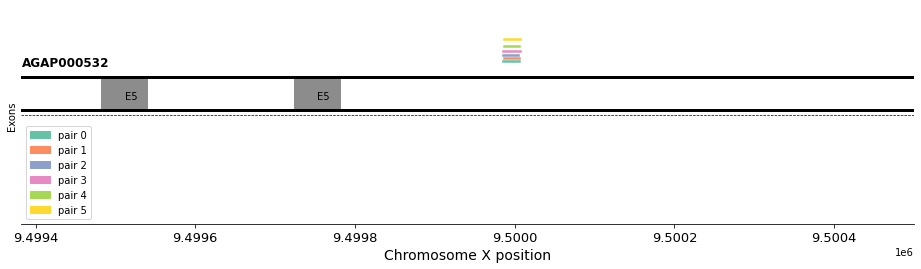

In [24]:
AgamPrimer.plot_primer_locs(primer_df=primer_df, primer_res_dict=results_dict, assay_type=assay_type, gff=ag3.geneset(), contig=contig, seq_parameters=seq_parameters, legend_loc='lower left')

In [25]:
primer_df

primer_pair,0,1,2,3,4,5
parameter,,,,,,
primer_probe_sequence,TGTGGGTTCCTTCCTTTGGCA,GTGGGTTCCTTCCTTTGGCA,TGTGGGTTCCTTCCTTTGGC,TGTGGGTTCCTTCCTTTGGCAT,TGGGTTCCTTCCTTTGGCA,GTGGGTTCCTTCCTTTGGCAT
primer_probe_tm,56.12102,54.550878,54.550878,56.357826,53.094331,54.864863
primer_probe_gc_percent,52.380952,55.0,55.0,50.0,52.631579,52.380952
primer_probe,"(194, 21)","(195, 20)","(194, 20)","(194, 22)","(196, 19)","(195, 21)"


### **Checking our primers for specificity to the *Anopheles gambiae* genome**

We can use a cool new python package, [gget](https://github.com/pachterlab/gget), to rapidly search our primers against the AgamP3 genome, to ensure they will not amplify any other regions of the genome. gget rapidly queries large databases - in this case we can use the program BLAT to align primer sequences. Unfortunately as the lengths of primer sequences are so short, it is at the limit of BLATs sensitivity, and in some cases, matches are not returned. gget can also currently only query the older AgamP3 assembly. Therefore, it is also recommended run a more exhaustive search in [Primer-BLAST](https://www.ncbi.nlm.nih.gov/tools/primer-blast/).

In [26]:
blat_result_df = AgamPrimer.gget_blat_genome(primer_df, assay_type, assembly='anoGam3')
blat_result_df

Wed Sep  7 16:22:14 2022 INFO No DNA BLAT matches were found for this sequence in genome anoGam3.


No hit for probe - pair 4


,,genome,query_size,aligned_start,aligned_end,matches,mismatches,%_aligned,%_matched,chromosome,strand,start,end
,primer,,,,,,,,,,,,
0,probe_0,anoGam3,21,1,21,21,0,100.0,100.0,chrX,+,9499985,9500005
1,probe_1,anoGam3,20,1,20,20,0,100.0,100.0,chrX,+,9499986,9500005
2,probe_2,anoGam3,20,1,20,20,0,100.0,100.0,chrX,+,9499985,9500004
3,probe_3,anoGam3,22,1,22,22,0,100.0,100.0,chrX,+,9499985,9500006
5,probe_5,anoGam3,21,1,21,21,0,100.0,100.0,chrX,+,9499986,9500006


####**We may now have designed suitable primers. However, there are some further considerations...**


- Primers **must** be run in [**NCBI Blast**](https://blast.ncbi.nlm.nih.gov/Blast.cgi), to ensure specificity against the host organism, and specificity for the genomic location of interest. I would recommend both doing a general blast and also specifically against *An. gambiae* (TaxonID = 7165).

- If in multiplexed use with other primers or probes, primers must not interact with each other. This can be investigated on a one by one basis using the IDT tool [oligoanalyzer](https://eu.idtdna.com/calc/analyzer), though higher throughput algorithms may be required.

- If designing Locked Nucleic Acid (LNA) probes for SNP detection, you will want to play around with the placement of LNAs in the oligo sequence, which can allow short probes (~10-14 bases) to bind with high affinity and discriminate between SNPs. IDT have a tool for this which allow you to check the binding affinity between mismatches, though it requires a log in https://eu.idtdna.com/calc/analyzer/lna. 

- Many more considerations.... [IDT - How to design primers and probes for PCR and qPCR](https://eu.idtdna.com/pages/education/decoded/article/designing-pcr-primers-and-probes)   

\
  

####**Future development**

Any contributions or suggestions on how we can improve this notebook are more than welcome. Please [email](mailto:sanjay.nagi@lstmed.ac.uk) or log an [issue on github](https://github.com/sanjaynagi/primerDesignAg/issues). This notebook and source code for AgamPrimer are located here - https://github.com/sanjaynagi/AgamPrimer/    

\
####**References**

The Anopheles gambiae 1000 Genomes Consortium (2020). **Genome variation and population structure among 1142 mosquitoes of the African malaria vector species *Anopheles gambiae* and *Anopheles coluzzii***. *Genome Research*, **30**: 1533-1546. 
https://genome.cshlp.org/content/early/2020/09/25/gr.262790.120

Untergasser A, Cutcutache I, Koressaar T, Ye J, Faircloth BC, Remm M and Rozen SG (2012). **Primer3--new capabilities and interfaces**. *Nucleic Acids Research*. 40(15):e115.